# Project 3 - Analysis of Panel Data
## Group Members:
1. Andrea Riccardo Assenza (006548376)
2. Kojo Manu (206545334)
3. Joshua Onozawa (506549019)
4. Rizky Rizaldi Ronaldo (706377502)

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random; random.seed(10)  # pre-setting seed
from scipy import stats
from scipy.stats import norm, chi2, f
import wooldridge as woo
from ydata_profiling import ProfileReport

# For model fitting
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.graphics import regressionplots
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, het_white, het_goldfeldquandt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegressionCV

# Subset regressions & feature selection
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Boruta
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

# Missing data imputation
from sklearn.impute import KNNImputer
from statsmodels.imputation import mice

# Model evaluation
from sklearn.metrics import *

# Ordered choice model
from statsmodels.miscmodels.ordinal_model import OrderedModel

# This just gets rid of annoying warnings
import warnings
warnings.filterwarnings("ignore")

# For R kernel
# Note: need working copy of R, initiate chunk with `%%R`
import rpy2.ipython
%load_ext rpy2.ipython

### List of Variables
* educ: Years of schooling
* ⁠exper: Years in workforce
* ⁠expersqr: Experience Squared
* ⁠union: Wage set by collective bargaining
* ⁠married: Married
* black: Black
* hisp: Hispanic
* ⁠poorhlth: Has health disability
* hours: Annual hours worked
* ⁠rur: Lives in rural area
* ⁠⁠nrtheast: Lives in North East
* ⁠nrthcen: Lives in Northern Central
* ⁠south: Lives in south
* ⁠lwage: Log of hourly wage

#### Industry Dummies
* ⁠AG: Agricultural
* ⁠⁠MIN: Mining
* ⁠⁠CON: Construction
* TRAD: Trade
* ⁠⁠TRA: Transportation
* ⁠FIN: Finance
* ⁠BUS: Business & Repair Service
* ⁠PER: Personal Service
* ⁠ENT: Entertainment
* ⁠⁠MAN: Manufacturing
* ⁠PRO: Professional & Related Service
* ⁠PUB: Public Administration

#### Occupational Dummies
* ⁠OCCI: Professional, Technical and kindred
* ⁠OCC2: Managers, Officials and Proprietors
* ⁠OCC3: Sales Workers
* ⁠OCC4: Clerical and kindred
* ⁠⁠OCC5: Craftsmen, Foremen and kindred
* ⁠OCC6: Operatives and kindred
* ⁠OCC7: Laborers and farmers
* ⁠⁠OCC8: Farm Laborers and Foreman
* ⁠OCC9: Service

In [3]:
# Variables
variables = [
    "educ",
    "exper",
    "expersq",  # updated from expersqr to expersq
    "union",
    "married",
    "black",
    "hisp",
    "poorhlth",
    "hours",
    "rur",
    "nrtheast",
    "nrthcen",
    "south",
    "lwage"
]

# Industry Dummies
industry_dummies = [
    "agric",    # was AG
    "min",      # was MIN
    "construc", # was CON
    "trad",     # was TRAD
    "tra",      # was TRA
    "fin",      # was FIN
    "bus",      # was BUS
    "per",      # was PER
    "ent",      # was ENT
    "manuf",    # was MAN
    "pro",      # was PRO
    "pub"       # was PUB
]

# Occupational Dummies
occupational_dummies = [
    "occ1",  # was OCCI
    "occ2",  # was OCC2
    "occ3",  # was OCC3
    "occ4",  # was OCC4
    "occ5",  # was OCC5
    "occ6",  # was OCC6
    "occ7",  # was OCC7
    "occ8",  # was OCC8
    "occ9"   # was OCC9
]

---
### 1. Briefly discuss your data and economic/finance/business question you are trying to answer with your model.
---

In this analysis, we aim to estimate the influence of union membership on wage-setting, commonly called the union wage premium. Specifically, we examine how wages vary between union and non-union workers and explore how this premium is associated with key individual characteristics.

To achieve this, we analyze data from the wage plan dataset in Wooldridge, which contains information on wages, individual characteristics, and employment details for a panel of workers. While the dataset includes many variables, we focus on a subset that captures the most relevant individual and contextual factors influencing wages and union membership. These variables include:

* Wages (`lwage`): The natural logarithm of hourly wages, the dependent variable of interest.
* Union Membership (`union`): The primary explanatory variable is a binary indicator (1 = union member, 0 = non-union member).
* Work Hours (`hours`): The total annual hours worked, reflecting labor supply and intensity.
* Experience (`exper`): The number of years of work experience, providing a proxy for skill accumulation.
* Experience Squared (`expersq`): The squared term of experience, capturing non-linear effects of experience on wages.
* Education (`educ`): The total years of schooling, representing human capital.
* Race (`black`): A binary indicator (1 = Black, 0 = otherwise), included to control for racial wage disparities.
* Rural Residency (`rur`): A binary variable indicating whether the individual resides in a rural area, accounting for regional differences in wage-setting.

Through this analysis, we aim to quantify the union wage premium while controlling for these individual characteristics, enabling us to better understand the role of unions in wage determination. By leveraging the data's panel structure, we can also account for unobserved heterogeneity across individuals and time periods, thereby improving the robustness of our estimates.

---
### 2. Provide a descriptive analysis of your variables. This should include histograms and fitted distributions, correlation plot, boxplots, scatterplots, and statistical summaries (e.g., the five-number summary). All figures must include comments.
---

In [4]:
wagepan = woo.data('wagepan')
wagepan.head()

,nr,year,agric,black,bus,construc,ent,exper,fin,hisp,...,union,lwage,d81,d82,d83,d84,d85,d86,d87,expersq
0,13,1980,0,0,1,0,0,1,0,0,...,0,1.197540,0,0,0,0,0,0,0,1
1,13,1981,0,0,0,0,0,2,0,0,...,1,1.853060,1,0,0,0,0,0,0,4
2,13,1982,0,0,1,0,0,3,0,0,...,0,1.344462,0,1,0,0,0,0,0,9
3,13,1983,0,0,1,0,0,4,0,0,...,0,1.433213,0,0,1,0,0,0,0,16
4,13,1984,0,0,0,0,0,5,0,0,...,0,1.568125,0,0,0,1,0,0,0,25


In [5]:
wagepan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4360 entries, 0 to 4359
Data columns (total 44 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   nr        4360 non-null   int64  
 1   year      4360 non-null   int64  
 2   agric     4360 non-null   int64  
 3   black     4360 non-null   int64  
 4   bus       4360 non-null   int64  
 5   construc  4360 non-null   int64  
 6   ent       4360 non-null   int64  
 7   exper     4360 non-null   int64  
 8   fin       4360 non-null   int64  
 9   hisp      4360 non-null   int64  
 10  poorhlth  4360 non-null   int64  
 11  hours     4360 non-null   int64  
 12  manuf     4360 non-null   int64  
 13  married   4360 non-null   int64  
 14  min       4360 non-null   int64  
 15  nrthcen   4360 non-null   int64  
 16  nrtheast  4360 non-null   int64  
 17  occ1      4360 non-null   int64  
 18  occ2      4360 non-null   int64  
 19  occ3      4360 non-null   int64  
 20  occ4      4360 non-null   int6

The dataset contains 4360 rows and 44 columns.

In [6]:
wagepan.describe()

,nr,year,agric,black,bus,construc,ent,exper,fin,hisp,...,union,lwage,d81,d82,d83,d84,d85,d86,d87,expersq
count,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000,...,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000,4360.000000
mean,5262.058716,1983.500000,0.032110,0.115596,0.075917,0.075000,0.015138,6.514679,0.036927,0.155963,...,0.244037,1.649147,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,50.424771
std,3496.149815,2.291551,0.176313,0.319777,0.264896,0.263422,0.122114,2.825873,0.188603,0.362862,...,0.429564,0.532609,0.330757,0.330757,0.330757,0.330757,0.330757,0.330757,0.330757,40.781991
min,13.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-3.579079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2329.000000,1981.750000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,...,0.000000,1.350717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000
50%,4569.000000,1983.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,...,0.000000,1.671143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000
75%,8406.000000,1985.250000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,...,0.000000,1.991086,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,81.000000
max,12548.000000,1987.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,...,1.000000,4.051860,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,324.000000


In [7]:
wagepan.isnull().sum()

nr          0
year        0
agric       0
black       0
bus         0
construc    0
ent         0
exper       0
fin         0
hisp        0
poorhlth    0
hours       0
manuf       0
married     0
min         0
nrthcen     0
nrtheast    0
occ1        0
occ2        0
occ3        0
occ4        0
occ5        0
occ6        0
occ7        0
occ8        0
occ9        0
per         0
pro         0
pub         0
rur         0
south       0
educ        0
tra         0
trad        0
union       0
lwage       0
d81         0
d82         0
d83         0
d84         0
d85         0
d86         0
d87         0
expersq     0
dtype: int64

There are no null data in any columns.

#### Histogram with KDE and Rugplots

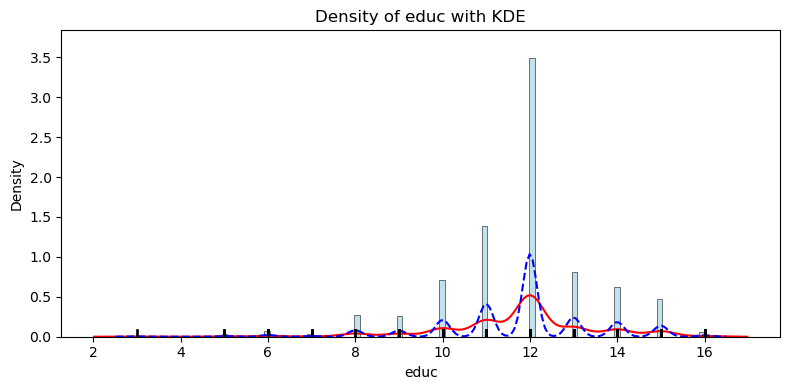

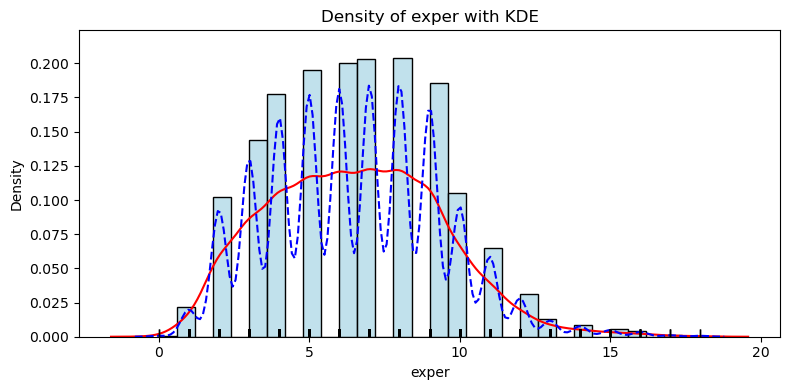

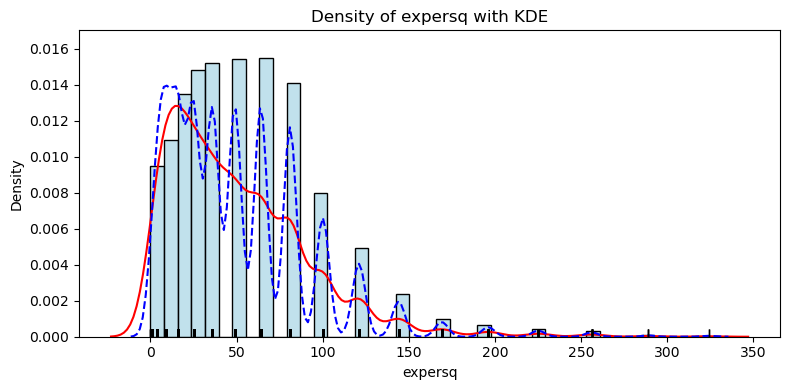

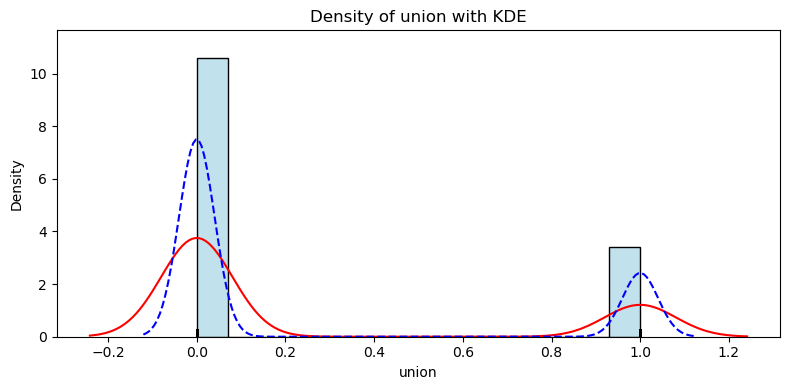

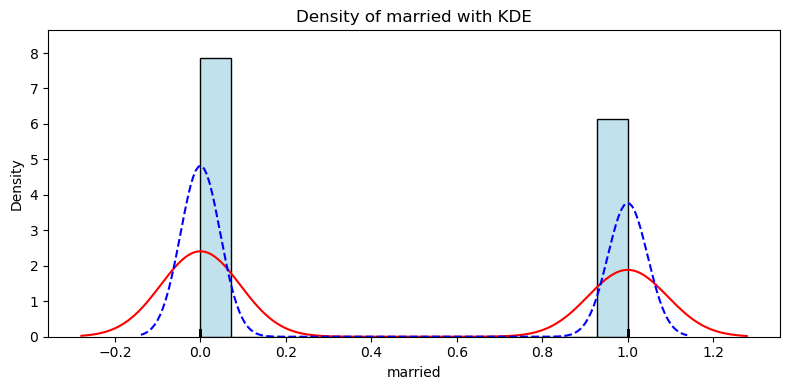

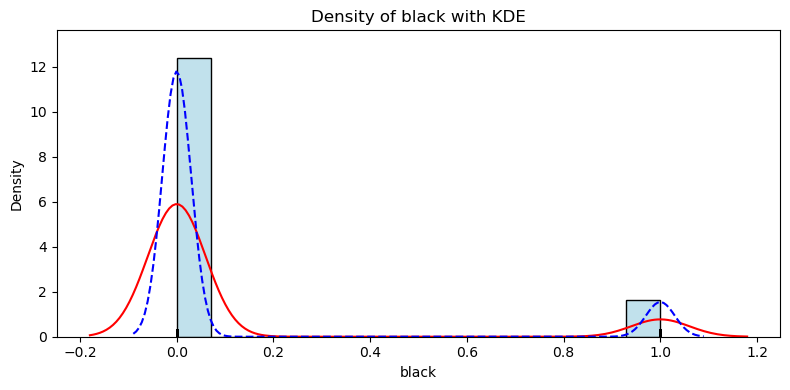

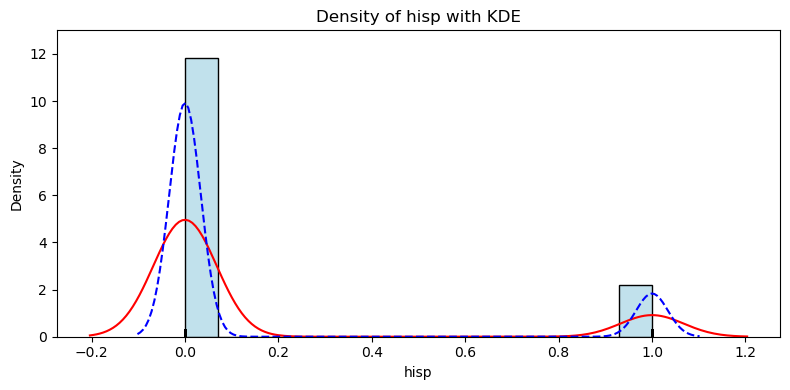

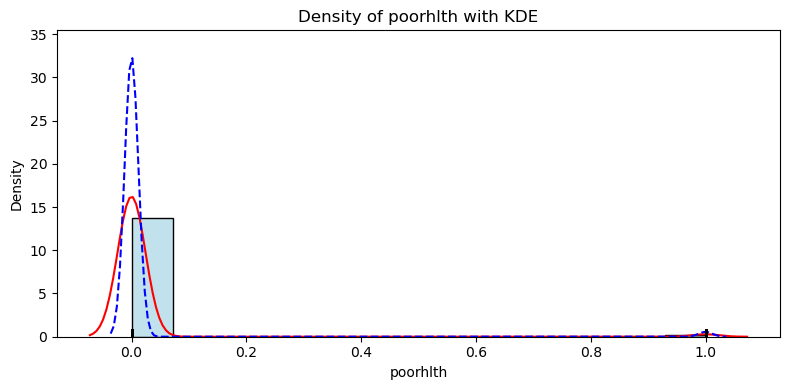

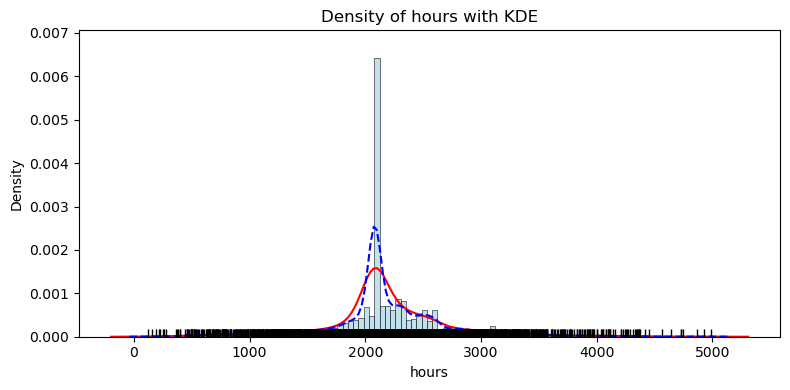

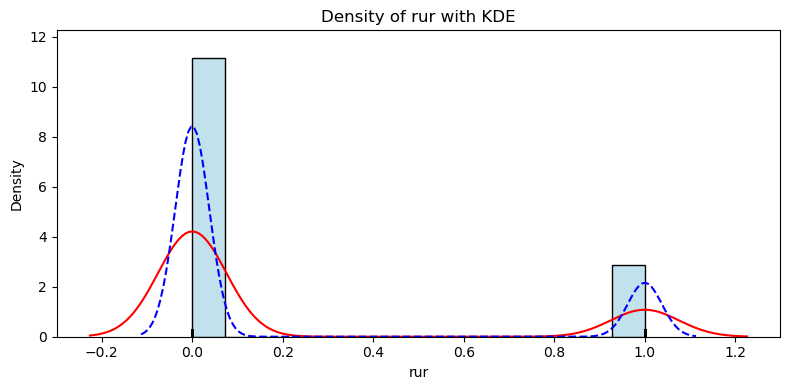

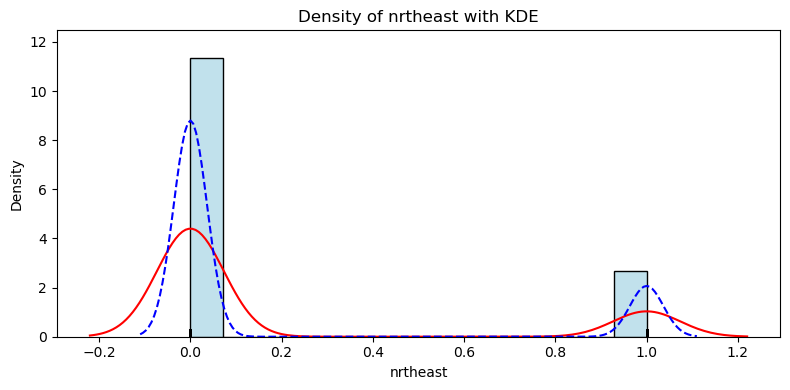

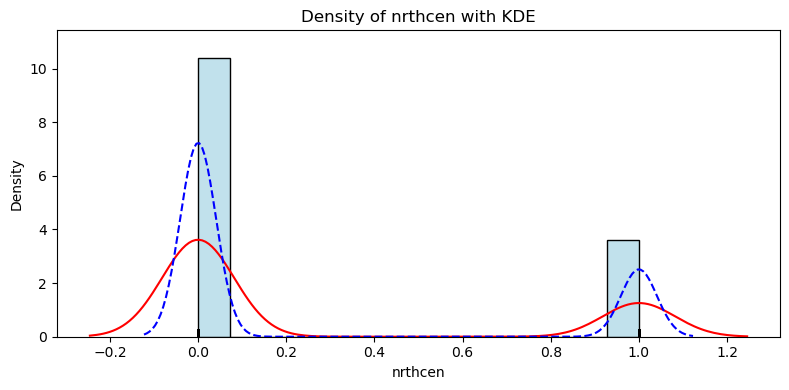

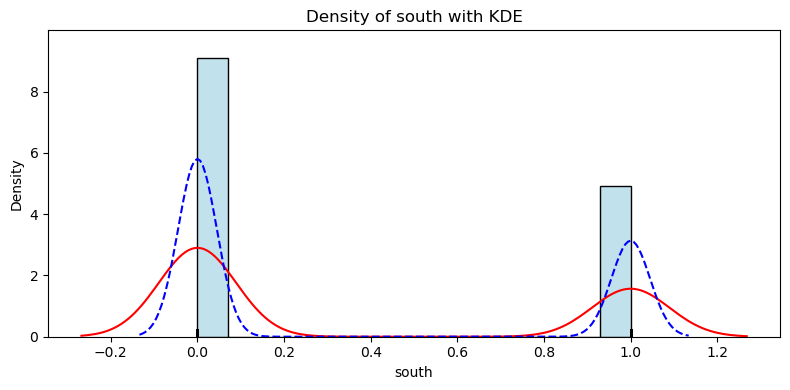

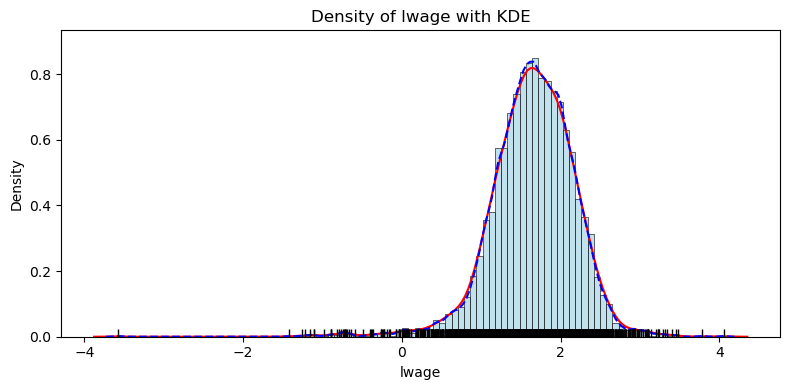

In [8]:
for col in variables:
    plt.figure(figsize=(8, 4))
    sns.histplot(wagepan[col], kde=False, stat='density', color='lightblue')
    sns.kdeplot(wagepan[col], color='red')
    sns.kdeplot(wagepan[col], bw_adjust=0.5, color='blue', linestyle='--')  # less smooth
    sns.rugplot(wagepan[col], color='black')
    plt.title(f'Density of {col} with KDE')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

**educ**
- The distribution has multiple peaks, indicating multimodality.
- Slight right skew with most density around 12 years of education.

**exper**
- Approximately uniform in the middle range with discrete peaks, suggesting stepwise increments in experience.
- Mild right skew; density reduces at higher experience levels.

**expersq**
- Highly right-skewed, reflecting the squared nature of the experience variable.
- Extreme right skew; most density at lower values.

**union**
- Bimodal distribution with peaks at 0 and 1, reflecting categorical nature (non-union vs. union members).
- Not symmetric, dominated by one mode at 0.

**married**
- Bimodal, with peaks at 0 and 1 indicating a binary variable (married or not).
- Slight dominance of the peak at 1, suggesting more married individuals.

**black**
- Bimodal peaks at 0 and 1, reflecting a categorical (binary) variable.
- Asymmetric, with more density around 0, indicating fewer individuals identifying as black.

**hisp**
- Bimodal peaks at 0 and 1 for the binary variable (Hispanic or not).
- Asymmetric, with a dominant peak at 0, indicating fewer Hispanic individuals.

**poorhlth**
- Bimodal peaks at 0 and 1, indicating self-reported health status.
- Skewed heavily toward 0, indicating most individuals do not report poor health; we will not use it in our predictions.

**hours**
- The distribution has a sharp peak around 2000 hours with a long right tail.
- The distribution is right-skewed, with a concentration of density near the peak and a gradual tapering toward higher hours.
- A log or square root transformation could help reduce the right skewness and normalize the distribution.

**rur**
- Bimodal peaks at 0 and 1 for rural vs. urban living.
- Asymmetric, with a higher peak at 0, suggesting more urban residents.

**nrtheast**
- Bimodal peaks at 0 and 1, corresponding to non-Northeast and Northeast residents.
- Slightly asymmetric, with fewer individuals residing in the Northeast.

**nrthcen**
- Bimodal peaks at 0 and 1 for non-North Central and North Central residents.
- Balanced peaks, though the peak at 1 is marginally higher.

**south**
- Bimodal peaks at 0 and 1, reflecting non-South vs. South regions.
- Slightly higher density at 1, indicating more individuals residing in the South.

**lwage**
- Approximately normal but with a long right tail, indicating wage distribution skewed positively.
- There is a slightly positive skew; most density is around the central value.

#### Q-Q Plots of Quantitative Variables

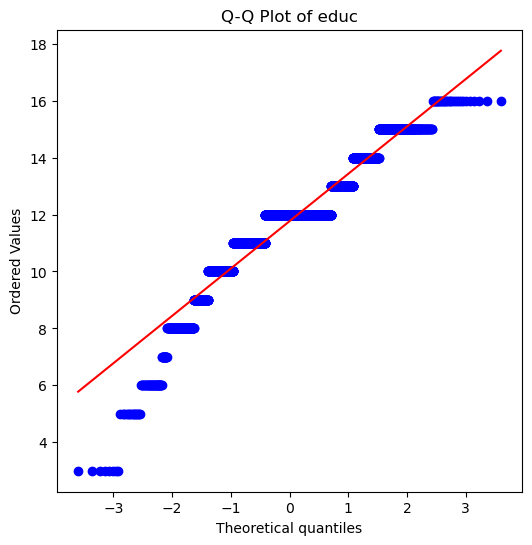

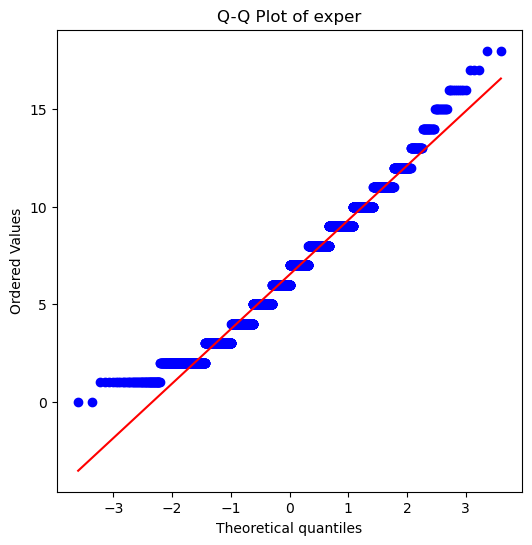

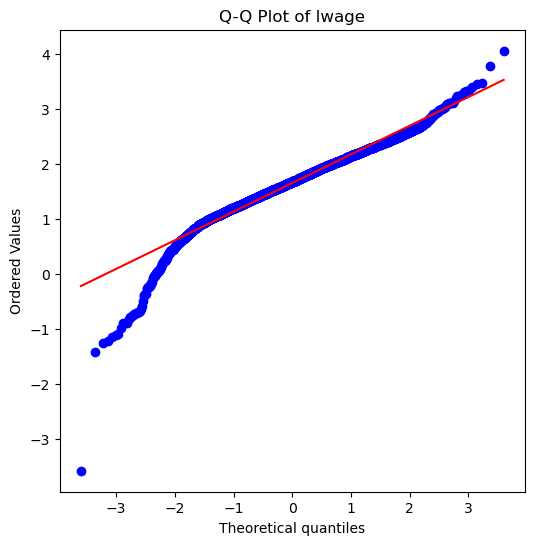

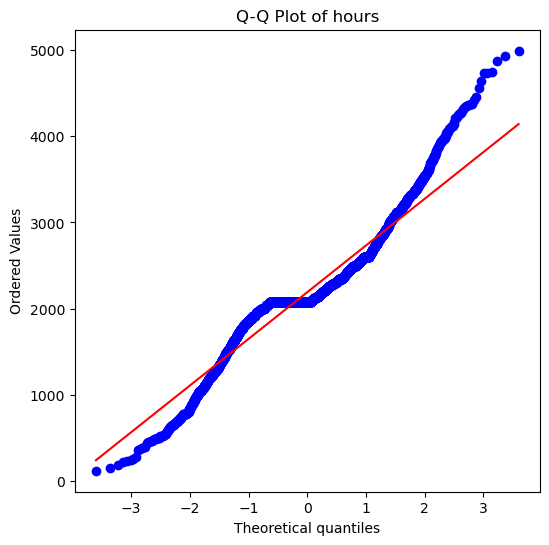

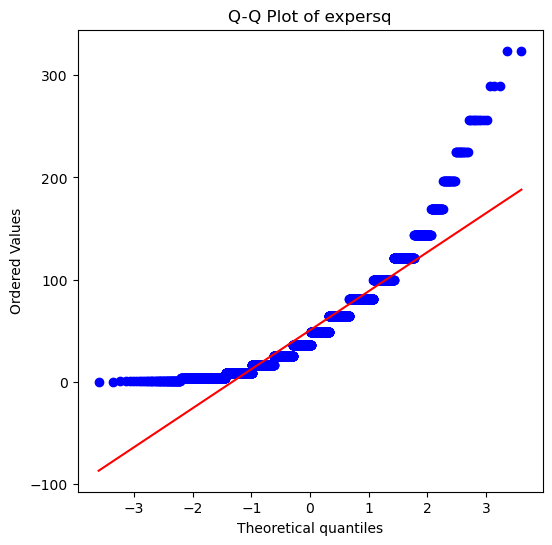

In [9]:
quantitative_vars = ['educ', 'exper', 'lwage', 'hours', 'expersq']

for var in quantitative_vars:
    # Q-Q Plot
    plt.figure(figsize=(6, 6))
    stats.probplot(wagepan[var], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {var}')
    plt.show()

**educ**
- The plot shows a stair-step pattern, indicating a discrete distribution. At the tails, points deviate slightly from the normal line.
- Values are clustered around whole numbers because our data only contains individuals who entered the labor force and completed their education.
- `educ` is a time-invariant characteristic of an individual.

**exper**
- The plot shows a stair-step pattern with slight deviations at the higher quantiles, suggesting a discrete nature.
- `exper` increases one-to-one with time.

**lwage**
- The points mostly follow the line but slightly deviate in the lower tail, indicating mild left skewness.
- No immediate transformation is necessary.

**hours**
- Strong deviations at the tails, particularly the upper tail, suggesting right skewness.
- A log or square root transformation is recommended to reduce skewness.

**expersq**
- The points deviate significantly from the normal line, particularly at the upper tail, indicating extreme right skewness.
- A square root transformation is appropriate to address the skewness caused by squaring.

#### Cullen-Frey Plots

summary statistics
------
min:  3   max:  16 
median:  12 
mean:  11.76697 
estimated sd:  1.746181 
estimated skewness:  -0.752002 
estimated kurtosis:  5.451977 


Loading required package: MASS
Loading required package: survival


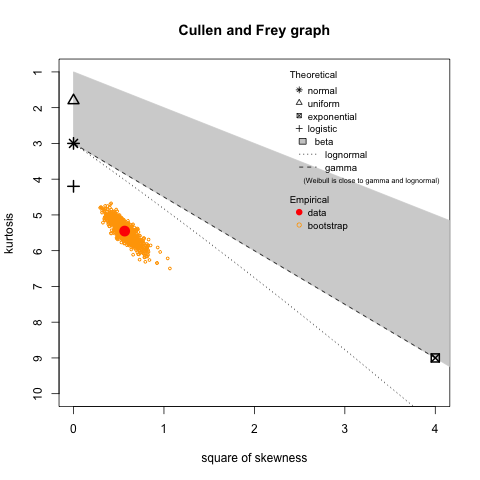

In [41]:
%%R -i wagepan
# Fitted distributions
set.seed(10)  # for reproducibility
library("fitdistrplus")
wagepan_continous <- wagepan[, c('educ', 'exper', 'lwage', 'hours', 'expersq')]
descdist(wagepan_continous$educ, boot = 1000)

From the result above, we can see that `educ` doesn't seem to follow any of the disributions, but it is closest to a logistic and lognormal distribution.

summary statistics
------
min:  0   max:  18 
median:  6 
mean:  6.514679 
estimated sd:  2.825873 
estimated skewness:  0.3180109 
estimated kurtosis:  2.892717 


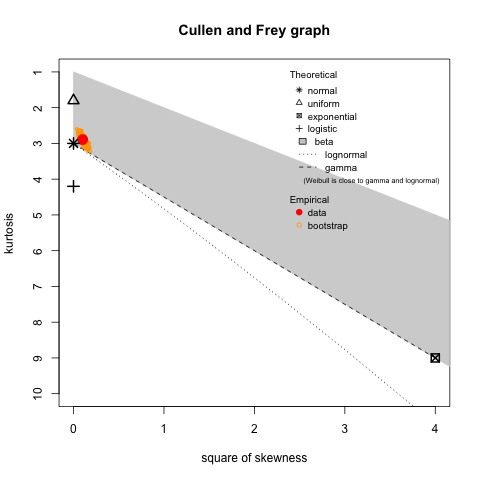

In [43]:
%%R -i wagepan
# Fitted distributions
set.seed(10)  # for reproducibility
library("fitdistrplus")
wagepan_continous <- wagepan[, c('educ', 'exper', 'lwage', 'hours', 'expersq')]
descdist(wagepan_continous$exper, boot = 1000)

The result above shows that `exper` seems to follow a normal distribution as it revolves closely around the asterisc sign.

summary statistics
------
min:  -3.579079   max:  4.05186 
median:  1.671143 
mean:  1.649147 
estimated sd:  0.5326094 
estimated skewness:  -0.9343927 
estimated kurtosis:  7.937193 


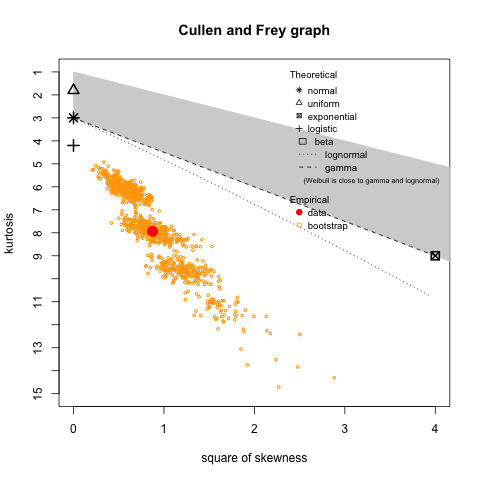

In [45]:
%%R -i wagepan
# Fitted distributions
set.seed(10)  # for reproducibility
library("fitdistrplus")
wagepan_continous <- wagepan[, c('educ', 'exper', 'lwage', 'hours', 'expersq')]
descdist(wagepan_continous$lwage, boot = 1000)

From the result above, we can see that `lwage` doesn't seem to follow any of the distributions closely, but its closest to a logistic and lognormal distribution.

summary statistics
------
min:  120   max:  4992 
median:  2080 
mean:  2191.257 
estimated sd:  566.3523 
estimated skewness:  0.3609155 
estimated kurtosis:  5.852407 


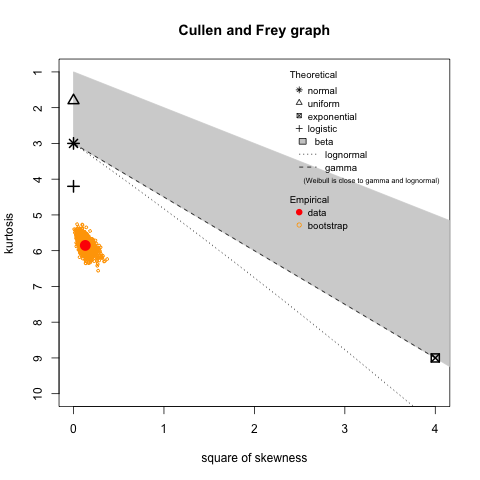

In [47]:
%%R -i wagepan
# Fitted distributions
set.seed(10)  # for reproducibility
library("fitdistrplus")
wagepan_continous <- wagepan[, c('educ', 'exper', 'lwage', 'hours', 'expersq')]
descdist(wagepan_continous$hours, boot = 1000)

From the result above, we can see that `hours` doesn't seem to follow any of the distributions closely, but it is closest to the logistic and lognormal distributions.

summary statistics
------
min:  0   max:  324 
median:  36 
mean:  50.42477 
estimated sd:  40.78199 
estimated skewness:  1.531203 
estimated kurtosis:  7.014504 


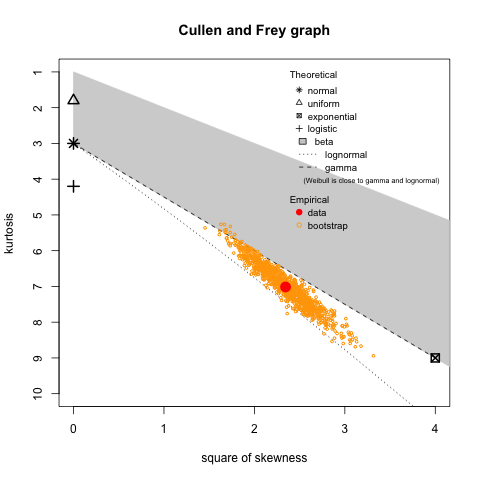

In [49]:
%%R -i wagepan
# Fitted distributions
set.seed(10)  # for reproducibility
library("fitdistrplus")
wagepan_continous <- wagepan[, c('educ', 'exper', 'lwage', 'hours', 'expersq')]
descdist(wagepan_continous$expersq, boot = 1000)

The result above shows that `expersq` seems to follow either a lognormal or a gamma distribution.

#### Correlation Matrix

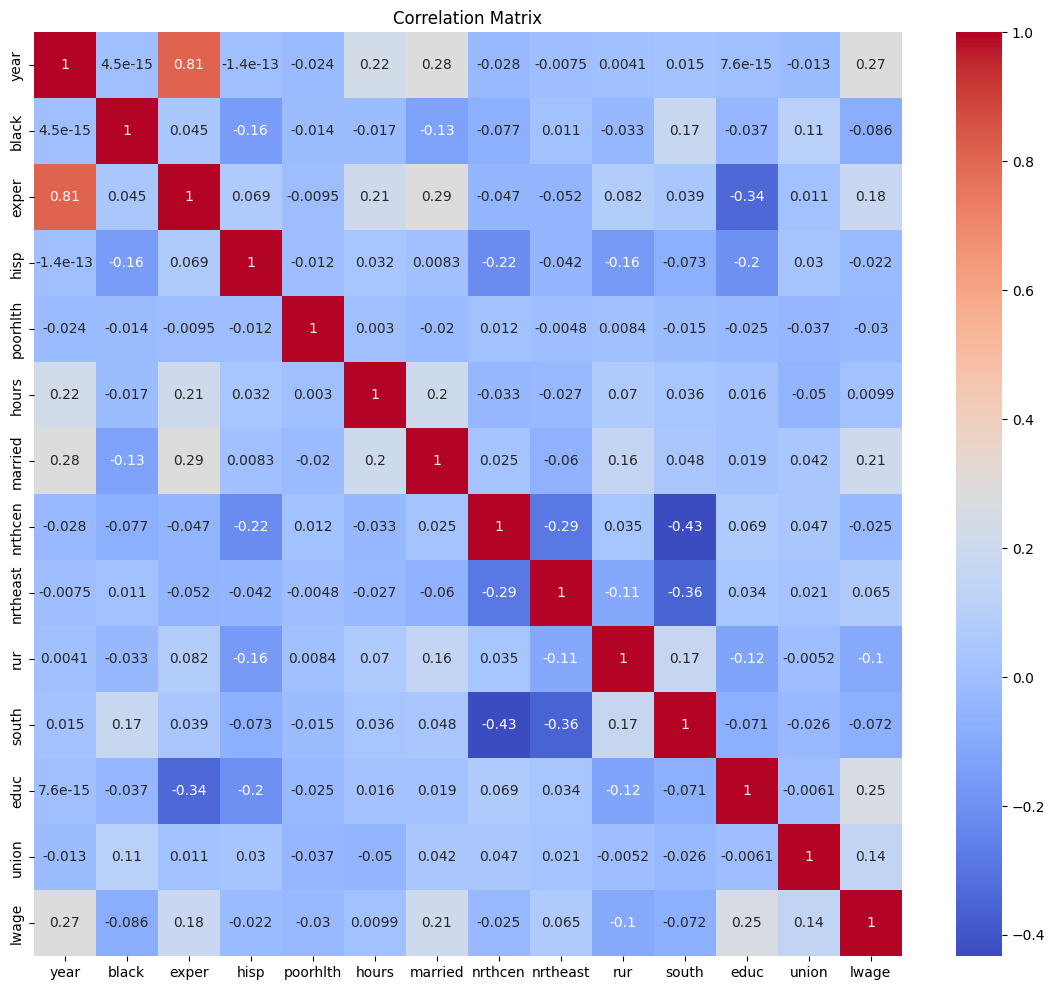

In [52]:
# Correlation plots
# we exclude industry and professional dummies and look at the correlation matrix
selection1 = wagepan[['year','black','exper','hisp','poorhlth','hours','married','nrthcen','nrtheast','rur','south','educ','union','lwage']]
corr_matrix = selection1.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

- `exper` and `year` have a very high correlation (0.81), but this is expected; experience increases one-to-one with time, so that we will keep `exper` at this stage.

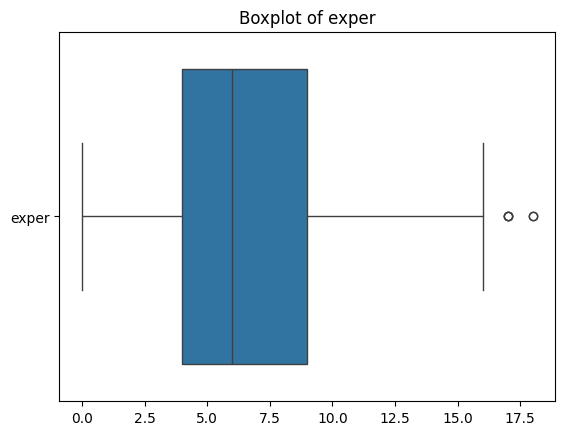

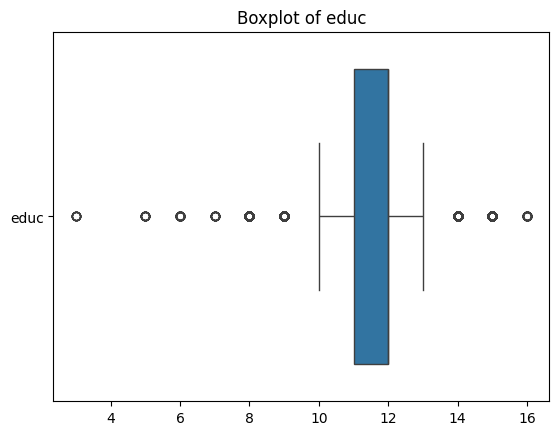

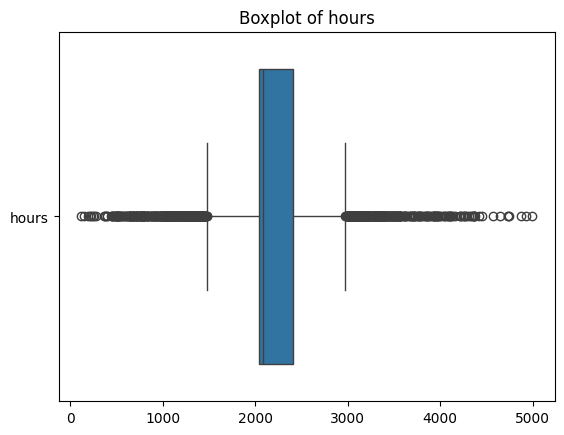

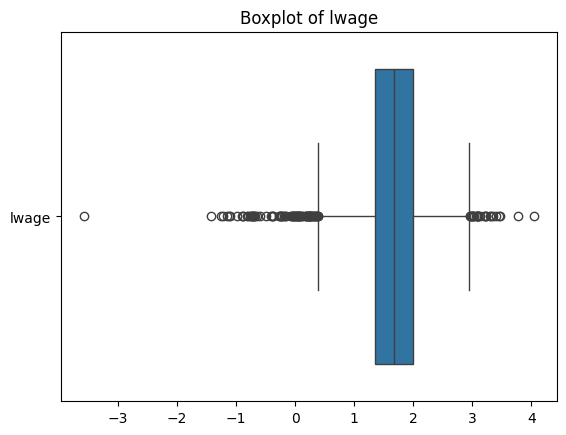

In [54]:
# Boxplots
for var in ['exper', 'educ', 'hours', 'lwage']:    
    sns.boxplot(data=selection1[[var]], orient="h")
    plt.title(f'Boxplot of {var}')
    plt.show()

We notice two observations outside the right (upper) whisker of the boxplot of `exper`, but they do not see so extreme as to be deemed outliers.
On the other hand, we want to drop the outlier that stands out to the left of the boxplot of `lwage` as it deviates significantly from the rest of our data.

In [56]:
(wagepan['lwage']<-2).sum()

1

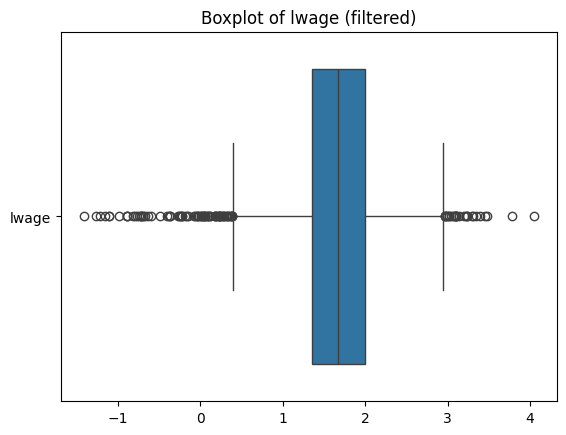

In [57]:
# Identify individuals with at least one observation where lwage < -2
individuals_to_drop = wagepan.loc[wagepan['lwage'] < -2, 'nr'].unique()

# Drop all observations for those individuals across all years
wagepan_filtered = wagepan[~wagepan['nr'].isin(individuals_to_drop)]

# Verify the individual was dropped
sns.boxplot(data=wagepan_filtered[['lwage']], orient="h")
plt.title('Boxplot of lwage (filtered)')
plt.show()

### Consider transformations of quantitative variables

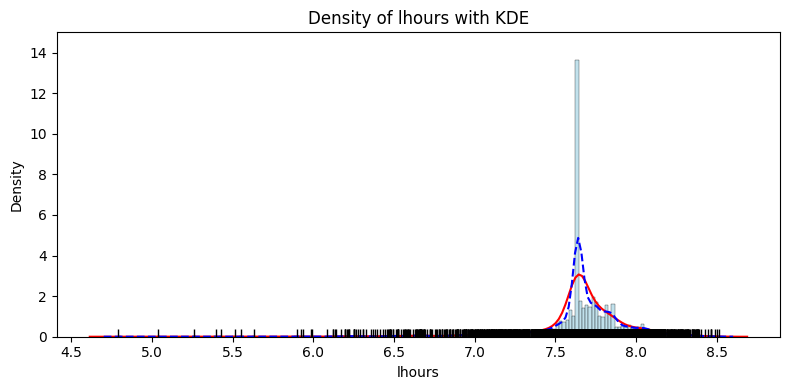

In [59]:
# log of hours
wagepan_filtered['lhours'] = np.log(wagepan_filtered['hours'])

wagepan_flt = wagepan_filtered

plt.figure(figsize=(8, 4))
sns.histplot(wagepan_flt['lhours'], kde=False, stat='density', color='lightblue')
sns.kdeplot(wagepan_flt['lhours'], color='red')
sns.kdeplot(wagepan_flt['lhours'], bw_adjust=0.5, color='blue', linestyle='--')  # less smooth
sns.rugplot(wagepan_flt['lhours'], color='black')
plt.title(f'Density of {'lhours'} with KDE')
plt.xlabel('lhours')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [60]:
def plotter(var, data):
    # Histogram and KDE
    plt.figure(figsize=(8, 4))
    sns.histplot(data[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()
    
    # Q-Q Plot
    plt.figure(figsize=(6, 6))
    stats.probplot(data[var], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {var}')
    plt.show()


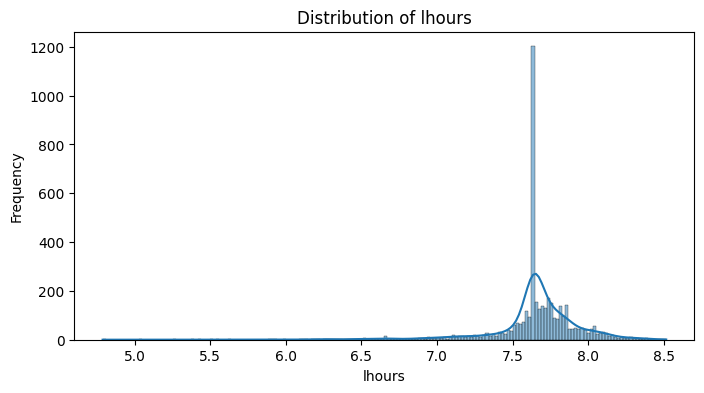

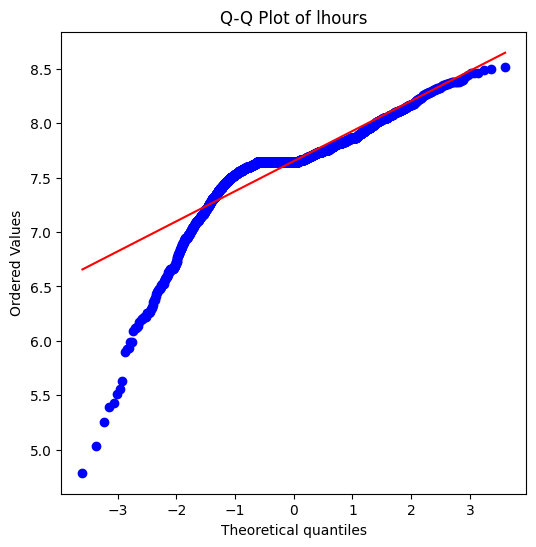

In [61]:
plotter('lhours', wagepan_flt)

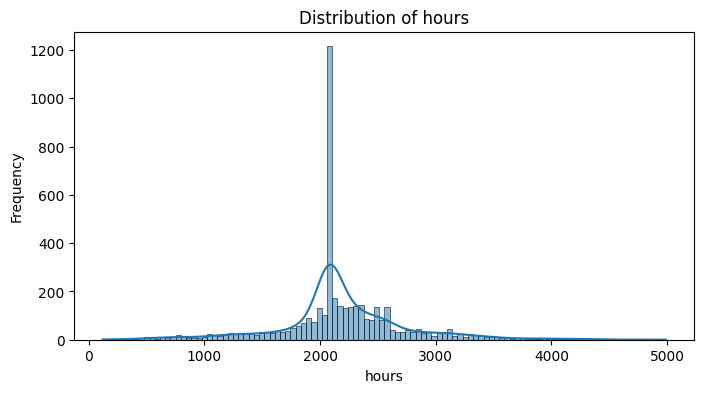

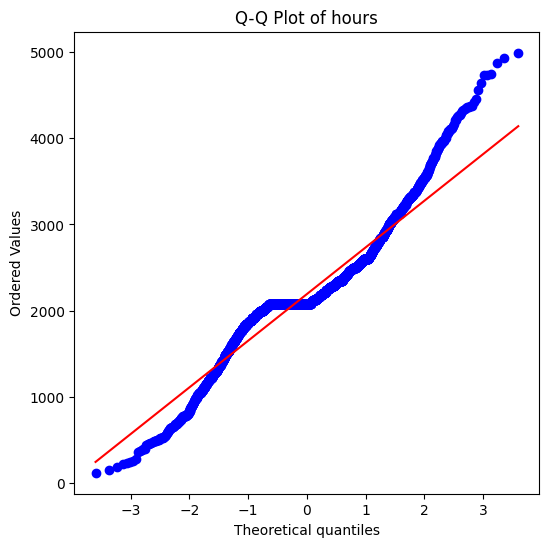

In [62]:
plotter('hours', wagepan_flt)

It might be better to keep `hours` untransformed; confirm with scatter plot with regression:

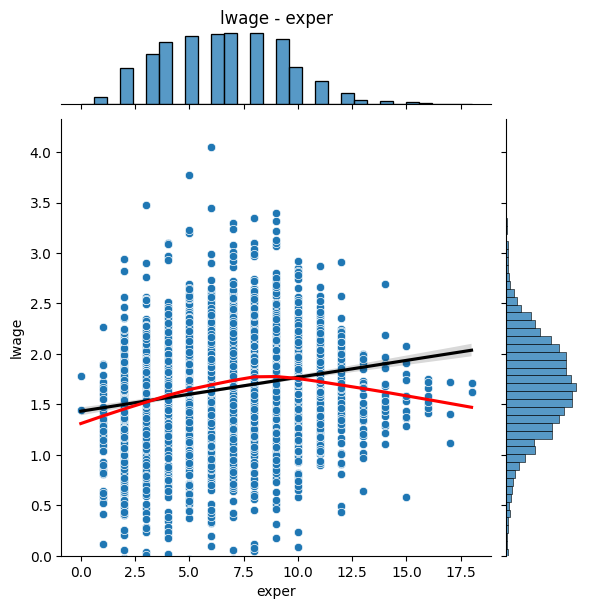

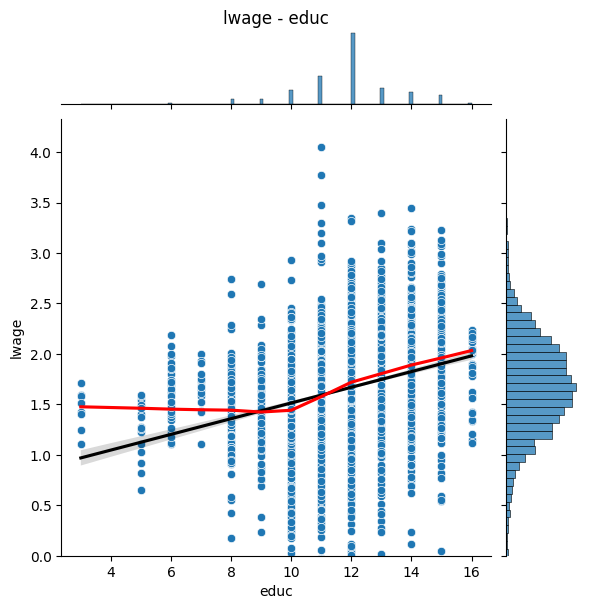

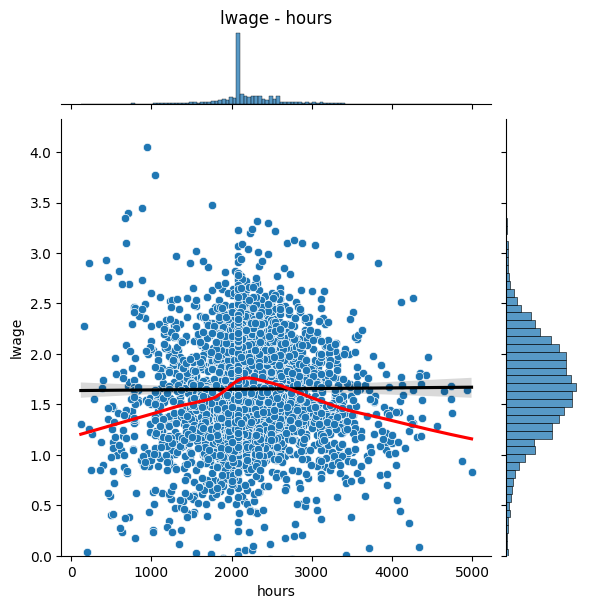

In [64]:
for var in ['exper', 'educ', 'hours']:
    t = sns.jointplot(data=wagepan_flt, x=var, y='lwage')
    t.plot_joint(sns.scatterplot)
    t.plot_joint(sns.regplot, fit_reg=True, scatter=False, color='black')
    t.plot_joint(sns.regplot, lowess=True, scatter=False, color='red')
    plt.ylim((0, None))
    plt.title(f'lwage - {var}', y=1.2)
    plt.show()

Based on the distribution plot, density plot, QQ plot, scatterplot, and regression plot, we can see that it is better to leave `hours` in its original form rather than transforming it into the logarithmic form.

---
## 3. Fit the three models below, and identify which model is your preferred one and why. Make sure to include eﬀects plots, statistical diagnostics, etc., to support your conclusion, and to comment on your findings. Models: (1) Pooled, (2) Fixed Eﬀects, and (3) Random Eﬀects
---

In [262]:
# Set panel data index
wagepan_panel = wagepan_flt.set_index(['nr', 'year'])

wagepan_panel.head(20)

agric  black  bus  construc  ent  exper  fin  hisp  poorhlth  hours  \
nr year                                                                        
13 1980      0      0    1         0    0      1    0     0         0   2672   
   1981      0      0    0         0    0      2    0     0         0   2320   
   1982      0      0    1         0    0      3    0     0         0   2940   
   1983      0      0    1         0    0      4    0     0         0   2960   
   1984      0      0    0         0    0      5    0     0         0   3071   
   1985      0      0    1         0    0      6    0     0         0   2864   
   1986      0      0    1         0    0      7    0     0         0   2994   
   1987      0      0    1         0    0      8    0     0         0   2640   
17 1980      0      0    0         0    0      4    0     0         0   2484   
   1981      0      0    0         0    0      5    0     0         0   2804   
   1982      0      0    0         0    0      6    0     0         0   2530   
   1983      0      0    0         0    0      7    0     0         0   2340   
   1984      0      0    0         0    0      8    0     0         0   2486   
   1985      0      0    0         1    0      9    0     0         0   2164   
   1986      0      0    0         1    0     10    0     0         0   2749   
   1987      0      0    0         1    0     11    0     0         0   2476   
18 1980      0      0    0         0    0      4    0     0         0   2332   
   1981      0      0    0         0    0      5    0     0         0   2116   
   1982      0      0    0         0    0      6    0     0         0   2500   
   1983      0      0    0         0    0      7    0     0         0   2474   

         ...     lwage  d81  d82  d83  d84  d85  d86  d87  expersq    lhours  
nr year  ...                                                                  
13 1980  ...  1.197540    0    0    0    0    0    0    0        1  7.890583  
   1981  ...  1.853060    1    0    0    0    0    0    0        4  7.749322  
   1982  ...  1.344462    0    1    0    0    0    0    0        9  7.986165  
   1983  ...  1.433213    0    0    1    0    0    0    0       16  7.992945  
   1984  ...  1.568125    0    0    0    1    0    0    0       25  8.029759  
   1985  ...  1.699891    0    0    0    0    1    0    0       36  7.959975  
   1986  ... -0.720263    0    0    0    0    0    1    0       49  8.004366  
   1987  ...  1.669188    0    0    0    0    0    0    1       64  7.878534  
17 1980  ...  1.675962    0    0    0    0    0    0    0       16  7.817625  
   1981  ...  1.518398    1    0    0    0    0    0    0       25  7.938802  
   1982  ...  1.559191    0    1    0    0    0    0    0       36  7.835975  
   1983  ...  1.725410    0    0    1    0    0    0    0       49  7.757906  
   1984  ...  1.622022    0    0    0    1    0    0    0       64  7.818430  
   1985  ...  1.608588    0    0    0    0    1    0    0       81  7.679714  
   1986  ...  1.572385    0    0    0    0    0    1    0      100  7.918992  
   1987  ...  1.820334    0    0    0    0    0    0    1      121  7.814400  
18 1980  ...  1.515963    0    0    0    0    0    0    0       16  7.754482  
   1981  ...  1.735379    1    0    0    0    0    0    0       25  7.657283  
   1982  ...  1.631744    0    1    0    0    0    0    0       36  7.824046  
   1983  ...  1.998229    0    0    1    0    0    0    0       49  7.813592  

[20 rows x 43 columns]

## 3.1. Pooled Model

We specificy a Pooled Model using the following variables, informed by economic intuition:
- `hours`: number of hours worked in a given year
- `exper` and `expersq`: years of work experience (and its square)
- `educ`: years of formal education
- `union`: whether the observed wage was determined through a union's contract
- `black` and `hispan`: race variables, where non-black and -hispanic constitute the baseline
- `nrtheast` and `nrthcen`: regional variables, where `south` constitute the baseline
- `rur`: whether the individual lives in a rural area or not

In [265]:
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects 
from linearmodels.panel import compare 

# Specify Pooled OLS
pooled_model = PooledOLS.from_formula(
    'lwage ~ 1 + hours + exper + expersq + educ + union + black + hisp + nrtheast + nrthcen + rur',
    data=wagepan_panel)

# Estimating basic model
pooled1 = pooled_model.fit()
print(pooled1.summary)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                        0.1987
Estimator:                  PooledOLS   R-squared (Between):              0.2104
No. Observations:                4352   R-squared (Within):               0.1849
Date:                Fri, Dec 06 2024   R-squared (Overall):              0.1987
Time:                        15:32:57   Log-likelihood                   -2900.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      107.65
Entities:                         544   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(10,4341)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             107.65
                            

In [266]:
# Estimate the Pooled OLS w/ cluster-robust standard errors, clustered at the entity level (using the index 'nr')
pooled2 = pooled_model.fit(cov_type='clustered', cluster_entity=True)

print(pooled2.summary)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                        0.1987
Estimator:                  PooledOLS   R-squared (Between):              0.2104
No. Observations:                4352   R-squared (Within):               0.1849
Date:                Fri, Dec 06 2024   R-squared (Overall):              0.1987
Time:                        15:32:57   Log-likelihood                   -2900.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      107.65
Entities:                         544   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(10,4341)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             44.933
                            

When using robust standard errors the coefficients of `nrtheast` and `nrthcen` become statistically insignificant, while the coefficient for `rur` remains statistically significant. This is likely to mean that what is driving the difference in wages is whether individuals live in rural or urban areas, which is certainly correlated with regions (some regions will have more people that live in rural areas compared to others). For this reason, we exclude regional variables from our model and retain `rur`.

In [268]:
# Alternative Pooled OLS w/ cluster-robust standard errors
pooled3 = PooledOLS.from_formula(
    'lwage ~ 1 + hours + exper + expersq + educ + union + black + hisp + rur',
    data=wagepan_panel).fit(cov_type='clustered', cluster_entity=True)

print(pooled3.summary)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                        0.1948
Estimator:                  PooledOLS   R-squared (Between):              0.2040
No. Observations:                4352   R-squared (Within):               0.1838
Date:                Fri, Dec 06 2024   R-squared (Overall):              0.1948
Time:                        15:32:57   Log-likelihood                   -2911.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      131.30
Entities:                         544   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(8,4343)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             55.567
                            

After dropping the regional variables from our model, we notice that the R-squared is almost unaffected while the F-stat increases. We also notice that the coefficient on `hispanic` is still statistically insignificant, meaning that being hispanic does not appear to affect wage levels compared to the baseline model (white individuals). Therefore, we drop the variable `hispan` from our model, meaning that all non-black individuals will now constitute our baseline.

In [270]:
# Alternative Pooled OLS w/ cluster-robust standard errors
pooled4 = PooledOLS.from_formula(
    'lwage ~ 1 + hours + exper + expersq + educ + union + black + rur',
    data=wagepan_panel).fit(cov_type='clustered', cluster_entity=True)

print(pooled4.summary)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                        0.1947
Estimator:                  PooledOLS   R-squared (Between):              0.2036
No. Observations:                4352   R-squared (Within):               0.1842
Date:                Fri, Dec 06 2024   R-squared (Overall):              0.1947
Time:                        15:32:57   Log-likelihood                   -2911.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      150.04
Entities:                         544   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(7,4344)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             62.471
                            

Now, we want to plot `lwage` with `year` to explore the presence of heterogeneity also across time.

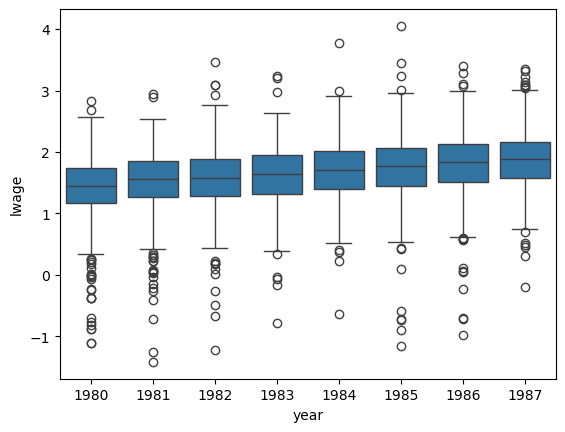

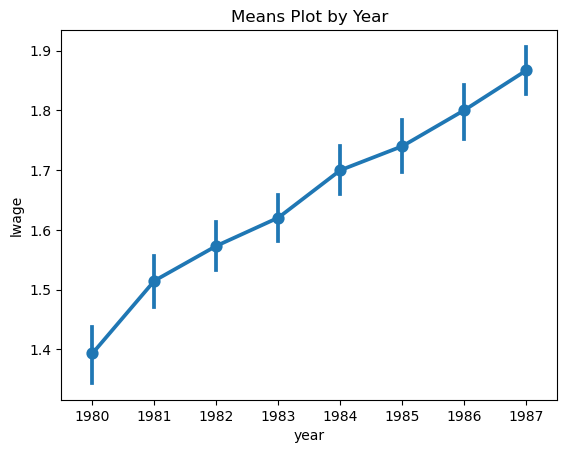

In [272]:
# We start by exploring heterogeneity across time (year) and individuals (nr)
sns.boxplot(wagepan_flt, x='year', y='lwage')
plt.show()

# Many outliers, we plot the means
sns.pointplot(wagepan_flt, x='year', y='lwage')
plt.title('Means Plot by Year')
plt.show()

From the means plot it appears clear that there is significant variation across time, meaning that a Fixed-effects model with Time Effects might be better suited to explain variations in our data.

Before running the Fixed-effects model, however, we also want to plot lwage with a sample of individuals to explore the presence of heterogeneity also across individuals.

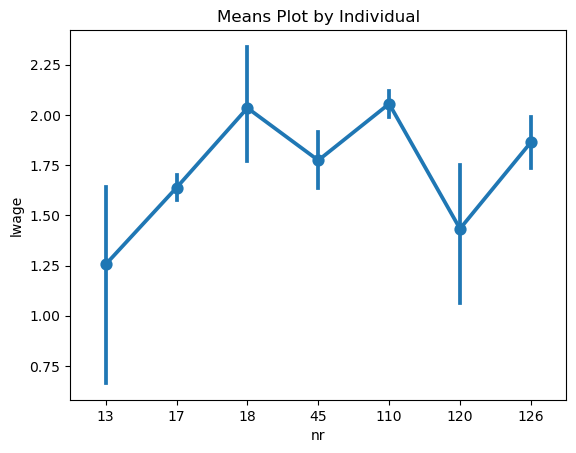

In [275]:
# Now we look at heterogeneity across individuals (first 7)
sns.pointplot(wagepan_panel.iloc[0:50], x='nr', y='lwage')
plt.title('Means Plot by Individual')
plt.show()

It is evident that variation across entities (individuals) is also present, meaning that a Fixed-effects model with Entity Effects might be better suited to explain variations in our data. 

## 3.2. Fixed Effects Models

Given the large number of entities in our data, we take a sample of 10 individuals to test and visualize a Fixed-effect model with Entity Effects only.

In [279]:
# Slice first 10 individuals
first10 = wagepan_flt.loc[[i in range(167) for i in wagepan_flt['nr']]]

# Fit dummy variable model
first10_dummyvar = smf.ols('lwage ~ hours + exper + expersq + educ + union + black + rur + C(nr) - 1', data=first10).fit()

print(first10_dummyvar.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     4.944
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           3.94e-06
Time:                        15:32:58   Log-Likelihood:                -30.413
No. Observations:                  80   AIC:                             90.83
Df Residuals:                      65   BIC:                             126.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C(nr)[13]     -0.4950      0.153     -3.233      0.0

Here, we plot the fitted values from this sample version of our Fixed-entity effects model to visualize variations across individuals with respect to the mean, as well as variations across time. This will also inform us on whether adding Time Effects might be appropriate.

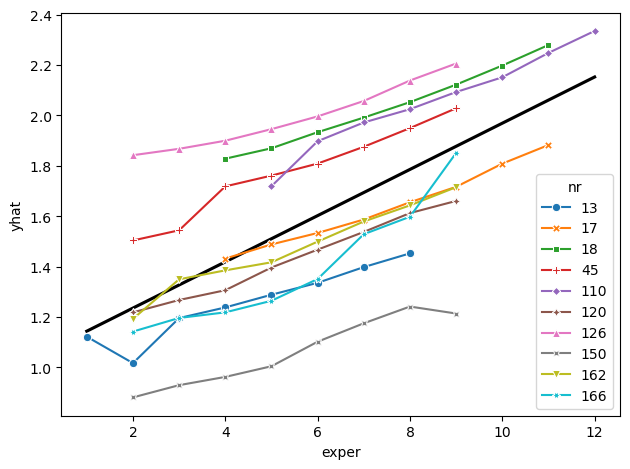

In [281]:
# Prepare plotting
first10_dummyvar_values = first10.copy()
first10_dummyvar_values= first10_dummyvar_values.astype({'nr': 'category'})
first10_dummyvar_values['yhat'] = first10_dummyvar.fittedvalues

# Plot
sns.regplot(first10_dummyvar_values, x='exper', y='yhat', ci=False, color='black', scatter=False)
# Then by individual
sns.lineplot(first10_dummyvar_values, x='exper', y='yhat', hue='nr', style='nr',
             dashes=False, markers=True)
plt.tight_layout()

# Bold black line is OLS fit

We notice roughly parallel trends for individuals across time, but at different wage levels, suggesting that a Fixed-effects model might perform better than the pooled effect one. The non-zero slope for all individuals considered hereby also suggests that including Time Effects could be appropriate.

This is simply a subset of the individuals we observe in our data. However, with this many observations we should use the 'Within Estimator' method.

In [284]:
# Using subsetted multi-index data frame
first10_panel = first10.set_index(['nr', 'year'])

# we remove 'educ' and 'black' as they do not take on more than one value for each individual across time and therefore generate 
# perfect mulitcollinearity with 'EntityEffects'
first10_fixeff = PanelOLS.from_formula(
    'lwage ~ hours + exper + expersq + union + rur + EntityEffects',
    data=first10_panel).fit(cov_type='clustered', cluster_entity=True)
print(first10_fixeff.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.1713
Estimator:                   PanelOLS   R-squared (Between):              0.3440
No. Observations:                  80   R-squared (Within):               0.1713
Date:                Fri, Dec 06 2024   R-squared (Overall):              0.3349
Time:                        15:32:58   Log-likelihood                   -30.413
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.6864
Entities:                          10   P-value                           0.0287
Avg Obs:                       8.0000   Distribution:                    F(5,65)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):         -2.639e+15
                            

When including entity effects in our model, we need to drop categorical variables denoting fixed characteristics of the individuals in our dataset, such as race and `educ` (which does not vary across time, given that our dataset only includes individuals that have already completed their education), as these are fully absorbed by the entity effects.

All coefficients are statistically insignificant. That is expected given that we are only considering 10 individuals and therefore have a very low number of observations.

In [287]:
# We print the effects for the first 3 individuals
first10_fixeff.estimated_effects.head(18)

estimated_effects
nr year                   
13 1980           1.022333
   1981           1.022333
   1982           1.022333
   1983           1.022333
   1984           1.022333
   1985           1.022333
   1986           1.022333
   1987           1.022333
17 1980           1.229542
   1981           1.229542
   1982           1.229542
   1983           1.229542
   1984           1.229542
   1985           1.229542
   1986           1.229542
   1987           1.229542
18 1980           1.630435
   1981           1.630435

As expect, we see substantially different estimated effects across different individuals.

In [289]:
# Using the whole data frame
fe = PanelOLS.from_formula(
    'lwage ~ 1 + hours + expersq + union + rur + EntityEffects + TimeEffects',
    data=wagepan_panel).fit(cov_type='clustered', cluster_entity=True)
print(fe.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.0477
Estimator:                   PanelOLS   R-squared (Between):             -0.1167
No. Observations:                4352   R-squared (Within):              -0.7963
Date:                Fri, Dec 06 2024   R-squared (Overall):             -0.4274
Time:                        15:32:58   Log-likelihood                   -1170.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      47.579
Entities:                         544   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(4,3797)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             23.304
                            

When including time effects in our model, we need to drop variables that move linearly with time, such as `exper` (one more year will necessarily equate to one more year of experience), as the effects of these are fully absorbed by the time effects.

### Comparison of Fixed-Effects models (multiple specifications) and Pooled model

In [292]:
# We compare the full fixed effects model to models only including either time or entity effects or no effects at all
# Full fixed effect (entity and time):
fe_full = smf.ols(
    'lwage ~ hours + expersq + union + rur + C(nr) + C(year)',
    data=wagepan_flt).fit()

# Only time
fe_time = smf.ols(
    'lwage ~ hours + expersq + union + rur + C(year)',
    data=wagepan_flt).fit()

# Only entity
fe_entity = smf.ols(
    'lwage ~ hours + expersq + union + rur + C(nr)',
    data=wagepan_flt).fit()

# Pooled (none)
fe_pooled = smf.ols(
    'lwage ~ hours + expersq + union + rur',
    data=wagepan_flt).fit()

# To test which effects are valid, we perform an ANOVA test

# both time and entity effects jointly
fe_case1 = sm.stats.anova_lm(fe_pooled, fe_full)
print('=== full vs pooled ===\n', fe_case1, '\n\n')

# controlling for time effects
fe_case2 = sm.stats.anova_lm(fe_time, fe_full)
print('=== full vs time ===\n', fe_case2, '\n\n')

# controlling for entity effects
fe_case3 = sm.stats.anova_lm(fe_entity, fe_full)
print('=== full vs entity ===\n', fe_case3)

=== full vs pooled ===
    df_resid          ssr  df_diff     ss_diff          F  Pr(>F)
0    4347.0  1142.634928      0.0         NaN        NaN     NaN
1    3797.0   436.422492    550.0  706.212436  11.171362     0.0 


=== full vs time ===
    df_resid          ssr  df_diff    ss_diff          F  Pr(>F)
0    4340.0  1061.714782      0.0        NaN        NaN     NaN
1    3797.0   436.422492    543.0  625.29229  10.018823     0.0 


=== full vs entity ===
    df_resid         ssr  df_diff    ss_diff          F        Pr(>F)
0    3804.0  473.996576      0.0        NaN        NaN           NaN
1    3797.0  436.422492      7.0  37.574084  46.700748  6.828625e-64


Given the results of the ANOVA tests, we conclude that the Full-Effects Model performs better than fixed effects models that only include entity or time effects, as well as the pooled model.

In [294]:
# We re-estimate the fixed effect models using 'PanelOLS.from_formula' to compare their coefficients
# Full fixed effect (entity and time):
fe_full_copy = PanelOLS.from_formula(
    'lwage ~ hours + expersq + union + rur + EntityEffects + TimeEffects',
    data=wagepan_panel).fit()

# Only time
fe_time_copy = PanelOLS.from_formula(
    'lwage ~ hours + expersq + union + rur + TimeEffects',
    data=wagepan_panel).fit()

# Only entity
fe_entity_copy = PanelOLS.from_formula(
    'lwage ~ hours + expersq + union + rur + EntityEffects',
    data=wagepan_panel).fit()

# Pooled (none)
fe_pooled_copy = PanelOLS.from_formula(
    'lwage ~ hours + expersq + union + rur',
    data=wagepan_panel).fit()


In [295]:
# We then compare model estimates

print(compare({
    'full': fe_full_copy,
    'fixed time': fe_time_copy,
    'fixed entity': fe_entity_copy,
    'pooled': fe_pooled_copy
}))

                                  Model Comparison                                 
                                  full     fixed time   fixed entity         pooled
-----------------------------------------------------------------------------------
Dep. Variable                    lwage          lwage          lwage          lwage
Estimator                     PanelOLS       PanelOLS       PanelOLS       PanelOLS
No. Observations                  4352           4352           4352           4352
Cov. Est.                   Unadjusted     Unadjusted     Unadjusted     Unadjusted
R-squared                       0.0477         0.0460         0.1406         0.8658
R-Squared (Within)             -0.7963        -0.1449         0.1406        -0.5106
R-Squared (Between)            -0.8040        -0.1844         0.0805         0.9265
R-Squared (Overall)            -0.8037        -0.1827         0.0830         0.8658
F-statistic                     47.579         52.272         155.53        

## 3.3. Random Effect Model & Hausman Test

In [297]:
# Random effects model
random = RandomEffects.from_formula(
    'lwage ~ 1 + hours + expersq + union + rur',
    data=wagepan_panel).fit(cov_type='clustered', cluster_entity=True)
print(random.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lwage   R-squared:                        0.1109
Estimator:              RandomEffects   R-squared (Between):             -0.0868
No. Observations:                4352   R-squared (Within):               0.1372
Date:                Fri, Dec 06 2024   R-squared (Overall):              0.0156
Time:                        15:33:00   Log-likelihood                   -1695.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      135.62
Entities:                         544   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(4,4347)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             76.151
                            

In [298]:
# Hausman test for fixed vs random effects model
# H0: random effects model
hausman_psi = fe.cov.iloc[1:,1:] - random.cov.iloc[1:,1:]       
hausman_diff = fe.params[1:] - random.params[1:]               
hausman_stat = hausman_diff @ np.linalg.inv(hausman_psi) @ hausman_diff     
hausman_df = random.params.size - 1
hausman_p = chi2.sf(hausman_stat, df=hausman_df)
print('Hausman Test: chisq = {0:.3f}, df = {1}, p-value = {2:.4}'.format(hausman_stat, hausman_df, hausman_p))

# Since p-value ~ 0, we choose fixed effects model

Hausman Test: chisq = 177.315, df = 4, p-value = 2.813e-37


The Hausman test result, for which we prefer the fixed-full effecs model to the random effects model was expected. This is because the random effects model assumes the correlation between any two individuals at the same point in time to be zero. However, there is a large number of common characteristic of individuals that can certainly affect their wage (such as industry, occupation, geography, etc.), thus creating a positive correlation of the wages of people belonging to the same sub-group of any of these characteristics.

Finally, we select the Fixed-Effects Model with both Entity Effects and Time Effects, and proceed to visualize notable features of our selected model.

## Selected Model Visualizations

In [345]:
# Full Fixed-Effects Model summary
fe

Dep. Variable:,lwage,R-squared:,0.0477
Estimator:,PanelOLS,R-squared (Between):,-0.1167
No. Observations:,4352,R-squared (Within):,-0.7963
Date:,"Fri, Dec 06 2024",R-squared (Overall):,-0.4274
Time:,15:32:58,Log-likelihood,-1170.9
Cov. Estimator:,Clustered,,
,,F-statistic:,47.579
Entities:,544,P-value,0.0000
Avg Obs:,8.0000,Distribution:,"F(4,3797)"
Min Obs:,8.0000,,
Max Obs:,8.0000,F-statistic (robust):,23.304


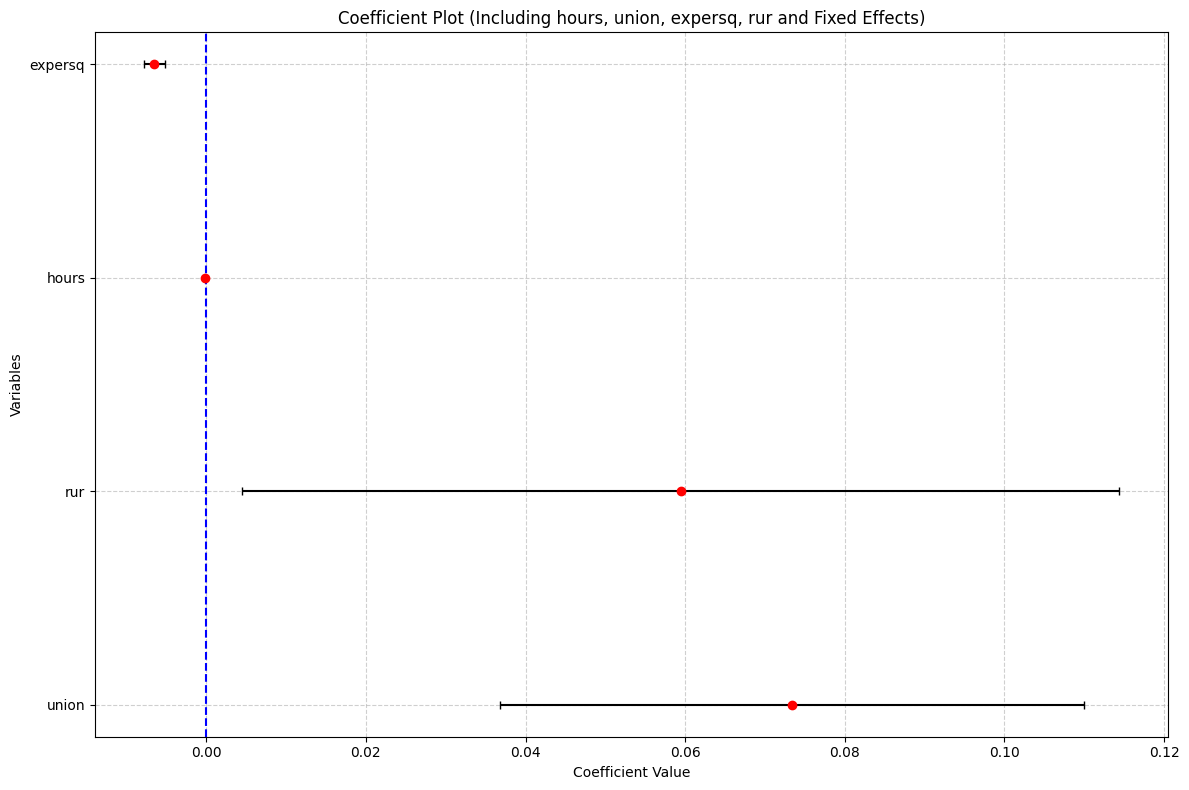

In [226]:
fe_full_coef = pd.DataFrame({
    'coef': fe_full.params,  # Estimated coefficients
    'upper_error': fe_full.conf_int()[1] - fe_full.params,  # Upper confidence interval - estimate
    'lower_error': fe_full.params - fe_full.conf_int()[0]   # Estimate - Lower confidence interval
})

# Sort coefficients by their values for better readability
fe_full_coef = fe_full_coef.sort_values(by='coef', ascending=False)

# Filter coefficients for the main variables of interest (hours, union, expersq, rur)
selected_variables = ['hours', 'union', 'expersq', 'rur']
filtered_coef = fe_full_coef.loc[
    fe_full_coef.index.str.contains('|'.join(selected_variables), case=False)
].copy()

# Create the plot
plt.figure(figsize=(12, 8))  # Adjust figure size to make it more readable
plt.axvline(x=0, color='blue', linestyle='--')  # Add a vertical line at zero for reference

# Plot error bars
plt.errorbar(
    x=filtered_coef['coef'], 
    y=filtered_coef.index, 
    xerr=(filtered_coef[['lower_error', 'upper_error']].values.T), 
    fmt='o', color='red', ecolor='black', capsize=3
)

# Titles and labels
plt.title("Coefficient Plot (Including hours, union, expersq, rur and Fixed Effects)")
plt.xlabel("Coefficient Value")
plt.ylabel("Variables")
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Tidy up layout
plt.tight_layout()
plt.show()

Notably, `union`, our variable of interest, is statistically significant at all levels of confidence and has the coefficient with the largest magnitude. With an estimated coefficient of 0.073, our model predicts individuals whose wages have been set through a union's contract to experience wages 7.3% higher than those of peers whose wages have not been set by unions, all else equal.

The coefficient on `rur` is not statistically significant, likely due to the fact that Entity Effects absorb much of its effect and that there is very little variation of the value of `rur` for individuals across time (few people in our dataset move from rural to non-rural areas, or vice versa, in the years from 1980 to 1987).

Finally, the coefficient on `hour` is almost exactly zero and statistically insignificant. This makes economic sense for a number of reason:
- Most people have full-time jobs and there is little variation in the number of hours worked across full-time jobs. This is also supported by the density plot of the variable, where we see a substantial spike a the mode.
- Given the little variation in hours, the "discriminating" factors in determining wages are likely to be characteristics such as education and experience, which are fully absorbed by Entity and Time Effects.

#### We proceed to plot the coefficients of year effects and entity effects (for selected individuals)

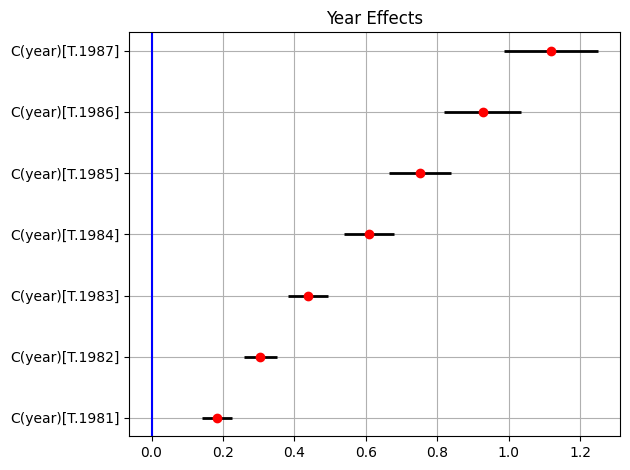

In [228]:
# Coefficient data frame
fe_full_coef = pd.DataFrame({
    'coef': fe_full.params,
    'error': fe_full.conf_int()[1] - fe_full.params # upper - estimate
})

# Visualizing year effects
fe_full_year_index = [p for p in fe_full.params.index if 'year' in p]
plt.axvline(x=0, color='blue')
plt.errorbar(x=fe_full_coef['coef'][fe_full_year_index], y=fe_full_year_index,
             xerr=fe_full_coef['error'][fe_full_year_index], # 95% confidence interval
             linestyle='', fmt='o', mfc='red', mec='red', ms=6, ecolor='black', lw=2)
plt.grid()
plt.title('Year Effects')
plt.tight_layout()

Coefficients on Year Effects are stadily increasing. A result in line with the steady increase of average wages over time that we noticed in previous plots.

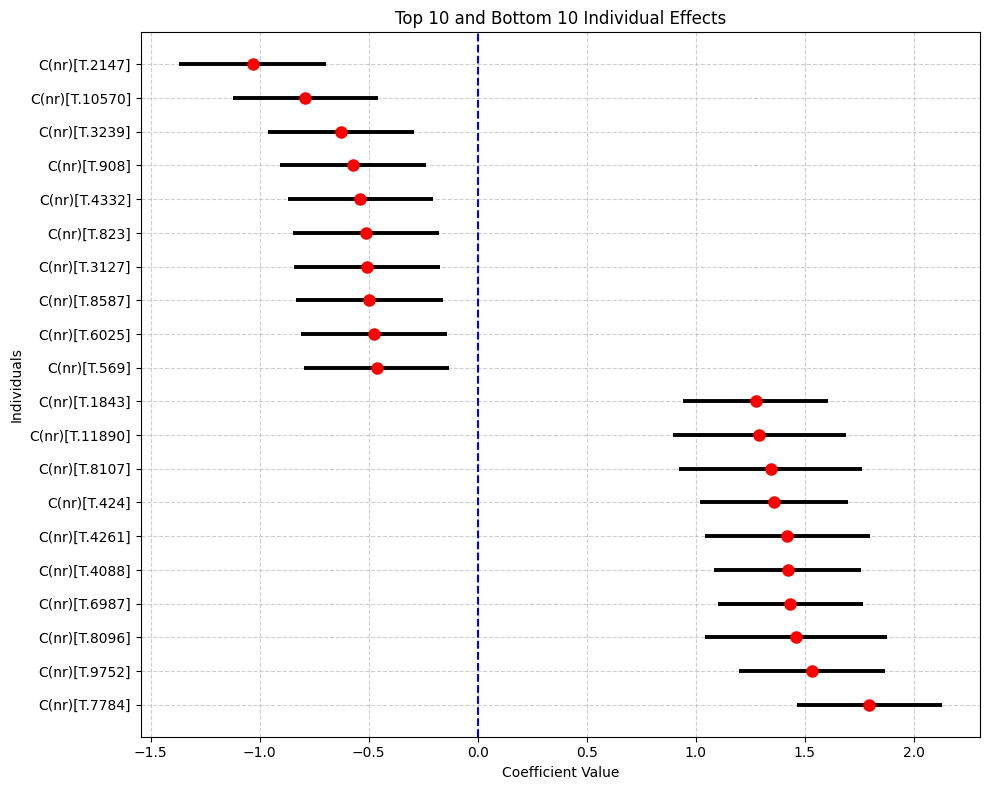

In [230]:
# Filter for entity effects
fe_full_entity_index = [p for p in fe_full.params.index if 'nr' in p]

# Extract entity effects into a DataFrame
entity_effects = pd.DataFrame({
    'coef': fe_full.params[fe_full_entity_index],
    'upper_error': fe_full.conf_int().iloc[:, 1][fe_full_entity_index] - fe_full.params[fe_full_entity_index],
    'lower_error': fe_full.params[fe_full_entity_index] - fe_full.conf_int().iloc[:, 0][fe_full_entity_index],
    'error': fe_full.conf_int().iloc[:, 1][fe_full_entity_index] - fe_full.conf_int().iloc[:, 0][fe_full_entity_index]
})

# Sort by coefficient values
entity_effects = entity_effects.sort_values(by='coef', ascending=False)

# Select the top 10 and bottom 10 entity effects
top_10_entity_effects = entity_effects.head(10)
bottom_10_entity_effects = entity_effects.tail(10)

# Combine top and bottom effects
top_bottom_entity_effects = pd.concat([top_10_entity_effects, bottom_10_entity_effects])

# Create the plot
plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
plt.axvline(x=0, color='blue', linestyle='--', linewidth=1.5)  # Add a vertical line at zero for reference

# Plot error bars for the top and bottom 10 entity effects
plt.errorbar(
    x=top_bottom_entity_effects['coef'],
    y=top_bottom_entity_effects.index,
    xerr=(top_bottom_entity_effects[['lower_error', 'upper_error']].values.T),
    fmt='o',
    mfc='red', mec='red', ms=8, ecolor='black', lw=2.8
)

# Add titles and labels
plt.title("Top 10 and Bottom 10 Individual Effects")
plt.xlabel("Coefficient Value")
plt.ylabel("Individuals")
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Tidy up layout
plt.tight_layout()
plt.show()

In terms of Entity Effects, plotting the top 10 and bottom 10 coefficients reveal how time-invariant individual characteristic play a large role in determining wages.

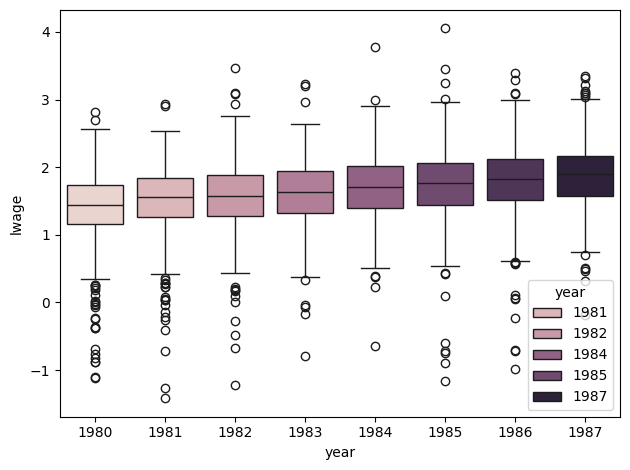

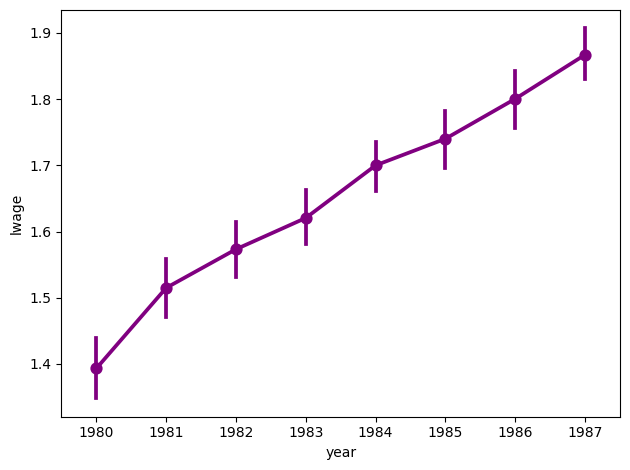

In [234]:
### Heterogeneity across time
# Box plot
sns.boxplot(wagepan_panel, x='year', y='lwage', hue='year')
plt.tight_layout()
plt.show()
# Means plot
sns.pointplot(wagepan_panel, x='year', y='lwage', color='purple')
plt.tight_layout()
plt.show()

We visualize the positive time trend in wages, which is captured by the Time Effects in our selected model.

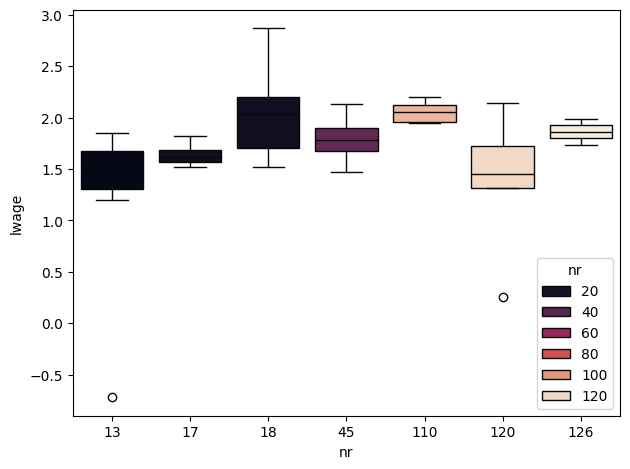

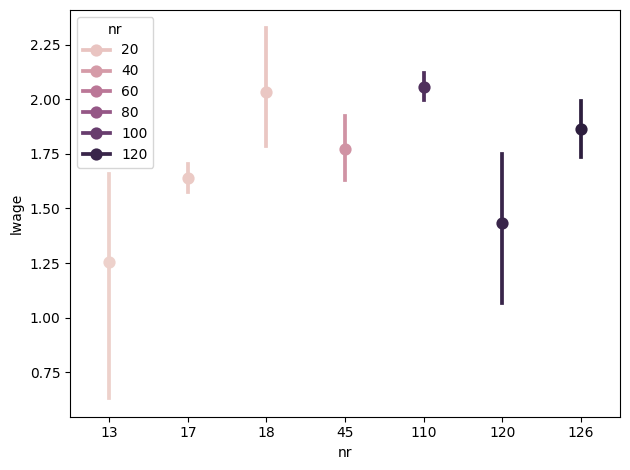

In [320]:
### Heterogeneity across individuals
# Box plot
sns.boxplot(wagepan_panel[0:50], x='nr', y='lwage', hue='nr', palette='rocket')
plt.tight_layout()
plt.show()
# Means plot
sns.pointplot(wagepan_panel[0:50], x='nr', y='lwage', hue='nr')
plt.tight_layout()
plt.show()

As we have noticed earlier as well, wages appear to vary substantially across individuals both in terms of level and variance.

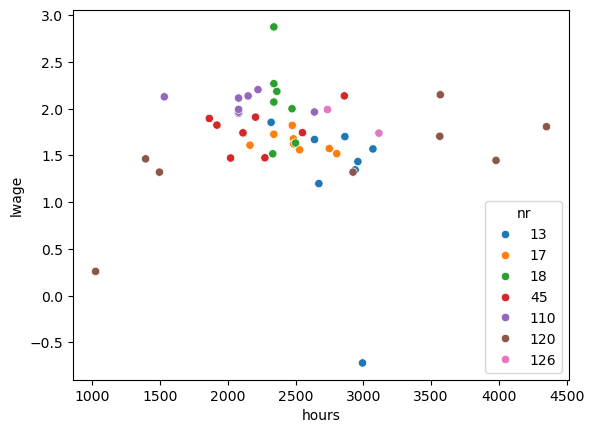

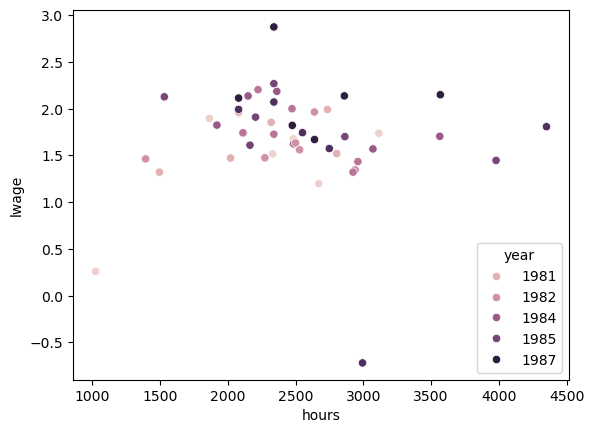

In [355]:
sns.scatterplot(wagepan_panel[0:50], y='lwage', x='hours', hue='nr', palette='tab10')
plt.show()

sns.scatterplot(wagepan_panel[0:50], y='lwage', x='hours', hue='year')
plt.show()

By plotting hours-wage value pairs and differentiating them first by individual and then by year, we still fail to notice any clear correlation between the hours worked by individuals and their wages, but there does seem to be a postive trends of wages as we move forward in time, with the highest values of `lwage` all being for observation in 1987 and 1985.

In [332]:
# Make extra data frame copy
wagepan_panel2 = wagepan_flt.copy()
wagepan_panel2['year'] = wagepan_flt['year'].astype('category')
wagepan_panel2['year2'] = wagepan_flt['year']                  # extra 'year' column to set as multi-index
wagepan_panel2.set_index(['nr', 'year2'], inplace=True)

# Fit within model
wagepan_fixeff = PanelOLS.from_formula(
    'lwage ~ hours + expersq + union + rur + EntityEffects + TimeEffects',
    data=wagepan_panel2).fit()

# entity effect
wagepan_fixeff.estimated_effects.filter(like='1981', axis=0)

,,estimated_effects
nr,year2,
13,1981,1.427544
17,1981,2.011952
18,1981,2.388059
45,1981,1.923670
110,1981,2.471103
...,...,...
12451,1981,1.745156
12477,1981,2.417269
12500,1981,1.707601


Finally, we provide entity-year pair estimated effects for a few individuals in our dataset for 1981, further highlighting the pretyy significant variance across these values.